# Anaylsis of the results

In [1]:
# load pickle
import pickle
from utils import *
import os
import re

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import matplotlib.gridspec as gridspec


# Set global font size
plt.rcParams.update({'font.size': 14})  # Change 14 to whichever fontsize you prefer


# Define colors for the datasets
color1 = plt.cm.Set2(1)
color2 = plt.cm.Set2(2)
color5 = plt.cm.Set2(5)

def extract_uppercase_letters(text):
    # Define the regex pattern to match the segment between "answer is" and the period.
    #check if text is already a list
    if isinstance(text, list):
        return text
    pattern = r'answer is ([^.]*?)\.'

    # Search the text for the pattern
    match = re.search(pattern, text)

    if match:
        # Extract the relevant segment
        segment = match.group(1)
        # Find all uppercase letters in the segment
        uppercase_letters = re.findall(r'[A-Z]', segment)
        return uppercase_letters
    else:
        return []
    
def evaluation_sampling_cot(llm_answer, exam_Answers, num_of_correct_answer):
    """Analyse the answer given by the LLM and compare it with the exam answers.

    Keyword arguments:
    llm_answer -- the answer string given by the LLM
    exam_Answers -- the list of answers from the exam
    """

    answerLLM = extract_uppercase_letters(llm_answer)
    if answerLLM is not None:
        num_of_correct_llm_Answers, too_many_answ, number_of_incorrect_llm_answers = compare_answers(answerLLM, exam_Answers)
        if num_of_correct_llm_Answers == num_of_correct_answer and too_many_answ == False:
            answered_correctly = True
        else:
            answered_correctly = False 
        return num_of_correct_llm_Answers, answerLLM, too_many_answ, answered_correctly, number_of_incorrect_llm_answers
    else:
         return -1
    
def update_stats_cot(llm_exam_result):
    for index, row in llm_exam_result.iterrows():
        #print(row["LLM_Answer"])
        num_of_correct_llm_answer, answerLLm, too_many_answers, answered_correctly, number_of_incorrect_llm_answers = evaluation_sampling_cot(row["LLM_Answer"], row["Exam_Answers"], row["NumberOfCorrectExamAnswers"])
        #modify the dataframe accordign to the evaluation
        llm_exam_result.at[index, 'NumberOfIncorrectLLMAnswers'] = number_of_incorrect_llm_answers
        llm_exam_result.at[index, 'NumberOfCorrectLLMAnswers'] = num_of_correct_llm_answer
        llm_exam_result.at[index, 'Ratio'] = num_of_correct_llm_answer/row["NumberOfCorrectExamAnswers"]
        llm_exam_result.at[index, 'Answered_Correctly'] = answered_correctly
        llm_exam_result.at[index, 'Too_Many_answers'] = too_many_answers
        llm_exam_result.at[index, 'NumberOfCorrectLLMAnswers'] = num_of_correct_llm_answer
    return llm_exam_result

def stats_from_pickle(folder_paths, cot=False):
    shuffled_evalutation_df = pd.DataFrame(columns=[ 'Number of Questions','Correctly Answered','Incorrectly Answered','Accuracy','Accuracy Partial'])

    pkl_files = []
    for folder_path in folder_paths:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if "shuffled" in file and file.endswith(".pkl"):
                    pkl_files.append(os.path.join(root, file))
                    
    for file in pkl_files:
        llm_exam_result = pickle.load(open(file, "rb"))
        #print(extract_uppercase_letters(llm_exam_result["LLM_Answer"][0]))
        if cot:
            llm_exam_result = update_stats_cot(llm_exam_result)
        evaluation_df = evaluation(llm_exam_result)
        #Concat the evaluation dataframe to the complete dataframe
        shuffled_evalutation_df = pd.concat([shuffled_evalutation_df, evaluation_df], ignore_index=True)
    model_statistics = calculate_model_statistics(shuffled_evalutation_df)
    #sort the model statistics by accuracy
    return model_statistics.sort_values(by="Accuracy Mean", ascending=False, ignore_index=True)


def apply_custom_settings(ax):
    # Set the y-axis major locator and formatter
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x * 100)}%'))
    
    # Apply grid settings
    ax.grid(True, axis='y')
    
    # Customize spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)


def plot_evaluation_CCNA(evaluation_df, hline_accuracy=None, hline_partial=None, title=None, save_path=None):
    """
    Plots evaluation metrics from a DataFrame containing columns:
        - 'Model'
        - 'Accuracy Mean', 'Accuracy Min', 'Accuracy Max'
        - 'Accuracy Partial Mean', 'Accuracy Partial Min', 'Accuracy Partial Max'
    """

    # Define a list of colors for the models
    colors = plt.cm.Set2(np.linspace(0, 1, len(evaluation_df)))

    # Define bar width
    bar_width = 0.5  # Increase bar width for thicker bars

    # --- Subplot 1: Accuracy ---
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    for a in ax:
        apply_custom_settings(a)


    for i, model in enumerate(evaluation_df['Model']):
        bars =ax.bar(i + bar_width * i, evaluation_df.loc[i, 'Accuracy Mean'], bar_width, 
                   yerr=[[abs(evaluation_df.loc[i, 'Accuracy Mean'] - evaluation_df.loc[i, 'Accuracy Min'])], [abs(evaluation_df.loc[i, 'Accuracy Max'] - evaluation_df.loc[i, 'Accuracy Mean'])]],
                   label=model, color=colors[i % len(colors)], capsize=5, alpha=0.75)

    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Accuracy Mean with Error Bars (Max and Min)', fontsize=14)
    ax[0].set_xticks([i + bar_width * i for i in range(len(evaluation_df['Model']))])
    ax[0].set_xticklabels(evaluation_df['Model'], rotation=45, ha='right', fontsize=14)
    #ax[0].legend()
    ax[0].set_ylim([0, 1])
    ax[0].yaxis.set_major_locator(mtick.MultipleLocator(0.1))
    ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax[0].grid(True, linestyle='dotted', axis='y')

    # Add horizontal line to Accuracy subplot
    if hline_accuracy is not None:
        ax[0].axhline(y=hline_accuracy, color='r', linestyle='--')

    # --- Subplot 2: Partial Accuracy ---
    for i, model in enumerate(evaluation_df['Model']):
        bars = ax[1].bar(i + bar_width * i, evaluation_df.loc[i, 'Accuracy Partial Mean'], bar_width,
                   yerr=[[abs(evaluation_df.loc[i, 'Accuracy Partial Mean'] - evaluation_df.loc[i, 'Accuracy Partial Min'])], [abs(evaluation_df.loc[i, 'Accuracy Partial Max'] - evaluation_df.loc[i, 'Accuracy Partial Mean'])]],
                   label=model, color=colors[i % len(colors)], capsize=5, alpha=0.75)

    ax[1].set_ylabel('Accuracy Partial (%)')
    ax[1].set_title('Accuracy Partial Mean with Error Bars (Max and Min)', fontsize=14)
    ax[1].set_xticks([i + bar_width * i for i in range(len(evaluation_df['Model']))])
    ax[1].set_xticklabels(evaluation_df['Model'], rotation=45, ha='right', fontsize=14)
    #ax[1].legend()
    ax[1].set_ylim([0.4, 1])
    ax[1].yaxis.set_major_locator(mtick.MultipleLocator(0.1))
    ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax[1].grid(True, linestyle='dotted', axis='y')

    # Add horizontal line to Partial Accuracy subplot
    if hline_partial is not None:
        ax[1].axhline(y=hline_partial, color='r', linestyle='--')

    fig.tight_layout(pad=1.2)  # Decrease padding for closer plots

    # Add title to the figure
    if title is not None:
        fig.suptitle(title, fontsize=16, y=1.05)

    plt.show()


def plot_evaluation_CCNA2(evaluation_df1, evaluation_df2,label1,label2, hline_accuracy=None, hline_partial=None, title=None, save_path=None):
    """
    Plots evaluation metrics from two DataFrames containing columns:
        - 'Model'
        - 'Accuracy Mean', 'Accuracy Min', 'Accuracy Max'
        - 'Accuracy Partial Mean', 'Accuracy Partial Min', 'Accuracy Partial Max'
    """

    # Define bar width
    bar_width = 0.35  # Modify bar width to fit both datasets side by side

    # --- Subplot 1: Accuracy ---
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    for a in ax:
        apply_custom_settings(a)

    for i, model in enumerate(evaluation_df1['Model']):
        bars1 = ax[0].bar(i, evaluation_df1.loc[i, 'Accuracy Mean'], bar_width, 
                   yerr=[[abs(evaluation_df1.loc[i, 'Accuracy Mean'] - evaluation_df1.loc[i, 'Accuracy Min'])], [abs(evaluation_df1.loc[i, 'Accuracy Max'] - evaluation_df1.loc[i, 'Accuracy Mean'])]],
                   label=label1 if i == 0 else "", color=color1, capsize=5, alpha=0.75)
        bars2 = ax[0].bar(i + bar_width, evaluation_df2.loc[i, 'Accuracy Mean'], bar_width,
                   yerr=[[abs(evaluation_df2.loc[i, 'Accuracy Mean'] - evaluation_df2.loc[i, 'Accuracy Min'])], [abs(evaluation_df2.loc[i, 'Accuracy Max'] - evaluation_df2.loc[i, 'Accuracy Mean'])]],
                   label=label2 if i == 0 else "", color=color2, capsize=5, alpha=0.75)

    ax[0].set_ylabel('Accuracy (%)')
    ax[0].set_title('Accuracy Mean with Error Bars (Max and Min)', fontsize=14)
    ax[0].set_xticks([i + bar_width / 2 for i in range(len(evaluation_df1['Model']))])
    ax[0].set_xticklabels(evaluation_df1['Model'], rotation=45, ha='right', fontsize=14)
    ax[0].legend()
    ax[0].set_ylim([0.4, 1])
    ax[0].yaxis.set_major_locator(mtick.MultipleLocator(0.1))
    ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax[0].grid(True, linestyle='dotted', axis='y')

    # Add horizontal line to Accuracy subplot
    if hline_accuracy is not None:
        ax[0].axhline(y=hline_accuracy, color='r', linestyle='--')

    # --- Subplot 2: Partial Accuracy ---
    for i, model in enumerate(evaluation_df1['Model']):
        bars1 = ax[1].bar(i, evaluation_df1.loc[i, 'Accuracy Partial Mean'], bar_width,
                   yerr=[[abs(evaluation_df1.loc[i, 'Accuracy Partial Mean'] - evaluation_df1.loc[i, 'Accuracy Partial Min'])], [abs(evaluation_df1.loc[i, 'Accuracy Partial Max'] - evaluation_df1.loc[i, 'Accuracy Partial Mean'])]],
                   label=label1 if i == 0 else "", color=color1, capsize=5, alpha=0.75)
        bars2 = ax[1].bar(i + bar_width, evaluation_df2.loc[i, 'Accuracy Partial Mean'], bar_width,
                   yerr=[[abs(evaluation_df2.loc[i, 'Accuracy Partial Mean'] - evaluation_df2.loc[i, 'Accuracy Partial Min'])], [abs(evaluation_df2.loc[i, 'Accuracy Partial Max'] - evaluation_df2.loc[i, 'Accuracy Partial Mean'])]],
                   label=label2 if i == 0 else "", color=color2, capsize=5, alpha=0.75)

    ax[1].set_ylabel('Accuracy Partial (%)')
    ax[1].set_title('Accuracy Partial Mean with Error Bars (Max and Min)', fontsize=14)
    ax[1].set_xticks([i + bar_width / 2 for i in range(len(evaluation_df1['Model']))])
    ax[1].set_xticklabels(evaluation_df1['Model'], rotation=45, ha='right', fontsize=14)
    ax[1].legend()
    ax[1].set_ylim([0.4, 1])
    ax[1].yaxis.set_major_locator(mtick.MultipleLocator(0.1))
    ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax[1].grid(True, linestyle='dotted', axis='y')

    # Add horizontal line to Partial Accuracy subplot
    if hline_partial is not None:
        ax[1].axhline(y=hline_partial, color='r', linestyle='--')

    fig.tight_layout(pad=1.2)  # Decrease padding for closer plots

    # Add title to the figure
    if title is not None:
        fig.suptitle(title, fontsize=16, y=1.05)

    plt.show()


def plot_evaluation_CCNA3(evaluation_df1, evaluation_df2,label1,label2, hline_accuracy=None, hline_partial=None, title=None, save_path=None):
    """
    Plots evaluation metrics from two DataFrames containing columns:
        - 'Model'
        - 'Accuracy Mean', 'Accuracy Min', 'Accuracy Max'
        - 'Accuracy Partial Mean', 'Accuracy Partial Min', 'Accuracy Partial Max'
    """

    # Define colors for the datasets
    color_diff = plt.cm.Paired(5)  # Color for the difference plot

    # Define bar width
    bar_width = 0.35  # Modify bar width to fit both datasets side by side

    # Calculate the Difference column
    evaluation_df1["Difference"] = evaluation_df1["Accuracy Partial Mean"] - evaluation_df1["Accuracy Mean"]
    evaluation_df2["Difference"] = evaluation_df2["Accuracy Partial Mean"] - evaluation_df2["Accuracy Mean"]

    # --- Subplot 1: Accuracy ---
    fig, ax = plt.subplots(1, 3, figsize=(21, 6))
    for a in ax:
        apply_custom_settings(a)

    for i, model in enumerate(evaluation_df1['Model']):
        bars1 = ax[0].bar(i, evaluation_df1.loc[i, 'Accuracy Mean'], bar_width, 
                   yerr=[[abs(evaluation_df1.loc[i, 'Accuracy Mean'] - evaluation_df1.loc[i, 'Accuracy Min'])], [abs(evaluation_df1.loc[i, 'Accuracy Max'] - evaluation_df1.loc[i, 'Accuracy Mean'])]],
                   label=label1 if i == 0 else "", color=color1, capsize=5, alpha=0.75)
        bars2 = ax[0].bar(i + bar_width, evaluation_df2.loc[i, 'Accuracy Mean'], bar_width,
                   yerr=[[abs(evaluation_df2.loc[i, 'Accuracy Mean'] - evaluation_df2.loc[i, 'Accuracy Min'])], [abs(evaluation_df2.loc[i, 'Accuracy Max'] - evaluation_df2.loc[i, 'Accuracy Mean'])]],
                   label=label2 if i == 0 else "", color=color2, capsize=5, alpha=0.75)

    ax[0].set_ylabel('Accuracy (%)')
    ax[0].set_title('Accuracy Mean with Error Bars (Max and Min)', fontsize=14)
    ax[0].set_xticks([i + bar_width / 2 for i in range(len(evaluation_df1['Model']))])
    ax[0].set_xticklabels(evaluation_df1['Model'], rotation=45, ha='right', fontsize=14)
    ax[0].legend()
    ax[0].set_ylim([0.4, 1])
    ax[0].yaxis.set_major_locator(mtick.MultipleLocator(0.1))
    ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax[0].grid(True, linestyle='dotted', axis='y')

    # Add horizontal line to Accuracy subplot
    if hline_accuracy is not None:
        ax[0].axhline(y=hline_accuracy, color='r', linestyle='--')

    # --- Subplot 2: Partial Accuracy ---
    for i, model in enumerate(evaluation_df1['Model']):
        bars1 = ax[1].bar(i, evaluation_df1.loc[i, 'Accuracy Partial Mean'], bar_width,
                   yerr=[[abs(evaluation_df1.loc[i, 'Accuracy Partial Mean'] - evaluation_df1.loc[i, 'Accuracy Partial Min'])], [abs(evaluation_df1.loc[i, 'Accuracy Partial Max'] - evaluation_df1.loc[i, 'Accuracy Partial Mean'])]],
                   label=label1 if i == 0 else "", color=color1, capsize=5, alpha=0.75)
        bars2 = ax[1].bar(i + bar_width, evaluation_df2.loc[i, 'Accuracy Partial Mean'], bar_width,
                   yerr=[[abs(evaluation_df2.loc[i, 'Accuracy Partial Mean'] - evaluation_df2.loc[i, 'Accuracy Partial Min'])], [abs(evaluation_df2.loc[i, 'Accuracy Partial Max'] - evaluation_df2.loc[i, 'Accuracy Partial Mean'])]],
                   label=label2 if i == 0 else "", color=color2, capsize=5, alpha=0.75)

    ax[1].set_ylabel('Accuracy Partial (%)')
    ax[1].set_title('Accuracy Partial Mean with Error Bars (Max and Min)', fontsize=14)
    ax[1].set_xticks([i + bar_width / 2 for i in range(len(evaluation_df1['Model']))])
    ax[1].set_xticklabels(evaluation_df1['Model'], rotation=45, ha='right', fontsize=14)
    ax[1].legend()
    ax[1].set_ylim([0, 1])
    ax[1].yaxis.set_major_locator(mtick.MultipleLocator(0.1))
    ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax[1].grid(True, linestyle='dotted', axis='y')

    # Add horizontal line to Partial Accuracy subplot
    if hline_partial is not None:
        ax[1].axhline(y=hline_partial, color='r', linestyle='--')

    # --- Subplot 3: Difference ---
    for i, model in enumerate(evaluation_df1['Model']):
        diff_bars1 = ax[2].bar(i, evaluation_df1.loc[i, 'Difference'], bar_width,
                     label=label1 if i == 0 else "", color=color1, capsize=5, alpha=0.75)
        diff_bars2 = ax[2].bar(i + bar_width, evaluation_df2.loc[i, 'Difference'], bar_width,
                     label=label2 if i == 0 else "", color=color2, capsize=5, alpha=0.75)

    ax[2].set_ylabel('Difference (Partial - Mean) (%)')
    ax[2].set_title('Difference between Partial and Mean Accuracy', fontsize=14)
    ax[2].set_xticks([i + bar_width / 2 for i in range(len(evaluation_df1['Model']))])
    ax[2].set_xticklabels(evaluation_df1['Model'], rotation=45, ha='right', fontsize=14)
    ax[2].legend()
    ax[2].grid(True, linestyle='dotted', axis='y')

    fig.tight_layout(pad=1.2)  # Decrease padding for closer plots

    # Add title to the figure
    if title is not None:
        fig.suptitle(title, fontsize=16, y=1.05)

    plt.show()

# Example usage:
# plot_evaluation_CCNA(evaluation_df1, evaluation_df2, hline_accuracy=0.8, hline_partial=0.5, title="Model Comparison")

def plot_evaluation_COT_5shot(evaluation_df1, evaluation_df2,label1,label2, hline_accuracy=None, hline_partial=None, title=None, save_path=None):
    """
    Plots evaluation metrics from two DataFrames containing columns:
        - 'Model'
        - 'Accuracy Mean', 'Accuracy Min', 'Accuracy Max'
        - 'Accuracy Partial Mean', 'Accuracy Partial Min', 'Accuracy Partial Max'
    """

    # Define colors for the datasets
    color_diff = plt.cm.Paired(5)  # Color for the difference plot

    # Define bar width
    bar_width = 0.35  # Modify bar width to fit both datasets side by side

    # Calculate the Difference column
    evaluation_df1["Difference"] = evaluation_df2["Accuracy Mean"] - evaluation_df1["Accuracy Mean"]

    # Create a GridSpec with 1 row and 3 columns
    fig = plt.figure(figsize=(14, 6))
    gs = gridspec.GridSpec(1, 3, width_ratios=[2, 1, 1])  # Set width ratios to make the second subplot half the size of the first one

    # Create the first subplot, which spans the first 2 columns
    ax1 = fig.add_subplot(gs[0, :2])
    apply_custom_settings(ax1)

    # Create the second subplot, which spans the third column
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x * 100)}%'))
    #make ax2 hald the horizontal size of ax1
    for i, model in enumerate(evaluation_df1['Model']):
        bars1 = ax1.bar(i, evaluation_df1.loc[i, 'Accuracy Mean'], bar_width, 
                   yerr=[[abs(evaluation_df1.loc[i, 'Accuracy Mean'] - evaluation_df1.loc[i, 'Accuracy Min'])], [abs(evaluation_df1.loc[i, 'Accuracy Max'] - evaluation_df1.loc[i, 'Accuracy Mean'])]],
                   label=label1 if i == 0 else "", color=color1, capsize=5, alpha=0.75)
        bars2 = ax1.bar(i + bar_width, evaluation_df2.loc[i, 'Accuracy Mean'], bar_width,
                   yerr=[[abs(evaluation_df2.loc[i, 'Accuracy Mean'] - evaluation_df2.loc[i, 'Accuracy Min'])], [abs(evaluation_df2.loc[i, 'Accuracy Max'] - evaluation_df2.loc[i, 'Accuracy Mean'])]],
                   label=label2 if i == 0 else "", color=plt.cm.Set2(6), capsize=5, alpha=1)

    ax1.set_ylabel('Accuracy (%)')
    #ax[0].set_title('Accuracy Mean with Error Bars (Max and Min)', fontsize=14)
    ax1.set_xticks([i + bar_width / 2 for i in range(len(evaluation_df1['Model']))])
    ax1.set_xticklabels(evaluation_df1['Model'], rotation=45, ha='right', fontsize=14)
    ax1.set_ylim([0.4, 1])
    ax1.legend()
    ax1.yaxis.set_major_locator(mtick.MultipleLocator(0.1))
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    ax1.grid(True, linestyle='dotted', axis='y')

    # Add horizontal line to Accuracy subplot
    if hline_accuracy is not None:
        ax1.axhline(y=hline_accuracy, color='r', linestyle='--')


    # --- Subplot 3: Difference ---
    for i, model in enumerate(evaluation_df1['Model']):
        diff_bars1 = ax2.bar(i, evaluation_df1.loc[i, 'Difference'], bar_width*2,
                     label="Diff. Mean Accuracy" if i == 0 else "", color=color_diff, capsize=5, alpha=0.75)

    ax2.set_ylabel('Difference (CoT - 5shot) (%)')
    ax2.set_xticks([i + bar_width for i in range(len(evaluation_df1['Model']))])
    ax2.set_xticklabels(evaluation_df1['Model'], rotation=45, ha='right', fontsize=14)

    ax2.grid(True, linestyle='dotted', axis='y')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_linewidth(0.5)

    # Add text below each subplot
    ax1.text(0.5, 1.05, '(a)', ha='center', va='center', transform=ax1.transAxes)
    ax2.text(0.5, 1.05, '(b)', ha='center', va='center', transform=ax2.transAxes)
    # Adjust layout to make room for the text
    plt.subplots_adjust(top=0.3)

    fig.tight_layout(pad=1.2)  # Decrease padding for closer plots

    # Add title to the figure
    if title is not None:
        fig.suptitle(title, fontsize=16, y=1.05)


    plt.savefig("plots/5-shot_cot.png", dpi=600, bbox_inches='tight')
    plt.show()

def plot_evaluation_CCNA_CCNP(evaluation_df1, evaluation_df2,label1,label2, hline_accuracy=None, hline_partial=None, title=None, save_path=None):
    """
    Plots evaluation metrics from two DataFrames containing columns:
        - 'Model'
        - 'Accuracy Mean', 'Accuracy Min', 'Accuracy Max'
        - 'Accuracy Partial Mean', 'Accuracy Partial Min', 'Accuracy Partial Max'
    """

    # Define colors for the datasets
    color_diff = plt.cm.Paired(5)  # Color for the difference plot

    # Define bar width
    bar_width = 0.35  # Modify bar width to fit both datasets side by side

    # Calculate the Difference column
    evaluation_df1["Difference"] = evaluation_df1["Accuracy Partial Mean"] - evaluation_df1["Accuracy Mean"]
    evaluation_df2["Difference"] = evaluation_df2["Accuracy Partial Mean"] - evaluation_df2["Accuracy Mean"]

    # Create a GridSpec with 1 row and 3 columns
    fig = plt.figure(figsize=(14, 6))
    gs = gridspec.GridSpec(1, 3, width_ratios=[2, 1, 1])  # Set width ratios to make the second subplot half the size of the first one

    # Create the first subplot, which spans the first 2 columns
    ax1 = fig.add_subplot(gs[0, :2])
    apply_custom_settings(ax1)

    # Create the second subplot, which spans the third column
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x * 100)}%'))
    #make ax2 hald the horizontal size of ax1
    for i, model in enumerate(evaluation_df1['Model']):
        bars1 = ax1.bar(i, evaluation_df1.loc[i, 'Accuracy Mean'], bar_width, 
                   yerr=[[abs(evaluation_df1.loc[i, 'Accuracy Mean'] - evaluation_df1.loc[i, 'Accuracy Min'])], [abs(evaluation_df1.loc[i, 'Accuracy Max'] - evaluation_df1.loc[i, 'Accuracy Mean'])]],
                   label=label1 if i == 0 else "", color=color1, capsize=5, alpha=0.75)
        bars2 = ax1.bar(i + bar_width, evaluation_df2.loc[i, 'Accuracy Mean'], bar_width,
                   yerr=[[abs(evaluation_df2.loc[i, 'Accuracy Mean'] - evaluation_df2.loc[i, 'Accuracy Min'])], [abs(evaluation_df2.loc[i, 'Accuracy Max'] - evaluation_df2.loc[i, 'Accuracy Mean'])]],
                   label=label2 if i == 0 else "", color=color2, capsize=5, alpha=0.75)

    ax1.set_ylabel('Accuracy (%)')
    #ax[0].set_title('Accuracy Mean with Error Bars (Max and Min)', fontsize=14)
    ax1.set_xticks([i + bar_width / 2 for i in range(len(evaluation_df1['Model']))])
    ax1.set_xticklabels(evaluation_df1['Model'], rotation=45, ha='right', fontsize=14)
    ax1.set_ylim([0.4, 1])
    ax1.legend()
    ax1.yaxis.set_major_locator(mtick.MultipleLocator(0.1))
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax1.grid(True, linestyle='dotted', axis='y')

    # Add text below each subplot
    ax1.text(0.5, 1.05, '(a)', ha='center', va='center', transform=ax1.transAxes)
    ax2.text(0.5, 1.05, '(b)', ha='center', va='center', transform=ax2.transAxes)
    # Adjust layout to make room for the text
    plt.subplots_adjust(top=0.3)


    # Add horizontal line to Accuracy subplot
    if hline_accuracy is not None:
        ax1.axhline(y=hline_accuracy, color='r', linestyle='--')


    # --- Subplot 3: Difference ---
    for i, model in enumerate(evaluation_df1['Model']):
        diff_bars1 = ax2.bar(i, evaluation_df1.loc[i, 'Difference'], bar_width,
                     label="Diff. Mean Accuracy" if i == 0 else "", color=color1, capsize=5, alpha=0.75)
        diff_bars2 = ax2.bar(i + bar_width, evaluation_df2.loc[i, 'Difference'], bar_width,
                     label="Diff. Mean Accuracy" if i == 0 else "", color=color2, capsize=5, alpha=0.75)

    ax2.set_ylabel('Difference to Partial Acc. (%)')
    ax2.set_xticks([i + bar_width for i in range(len(evaluation_df1['Model']))])
    ax2.set_xticklabels(evaluation_df1['Model'], rotation=45, ha='right', fontsize=14)

    ax2.grid(True, linestyle='dotted', axis='y')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_linewidth(0.5)

    fig.tight_layout(pad=1.2)  # Decrease padding for closer plots

    # Add title to the figure
    if title is not None:
        fig.suptitle(title, fontsize=16, y=1.05)

    
    plt.savefig("plots/ccna_ccnp_comparison.png", dpi=600, bbox_inches='tight')
    plt.show()

# Example usage:
# plot_evaluation_CCNA(evaluation_df1, evaluation_df2, hline_accuracy=0.8, hline_partial=0.5, title="Model Comparison")

# CCNA & CCNP 5 Shot Anaylsis

/tmp/ipykernel_146708/2844832456.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  shuffled_evalutation_df = pd.concat([shuffled_evalutation_df, evaluation_df], ignore_index=True)
/tmp/ipykernel_146708/2844832456.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  shuffled_evalutation_df = pd.concat([shuffled_evalutation_df, evaluation_df], ignore_index=True)


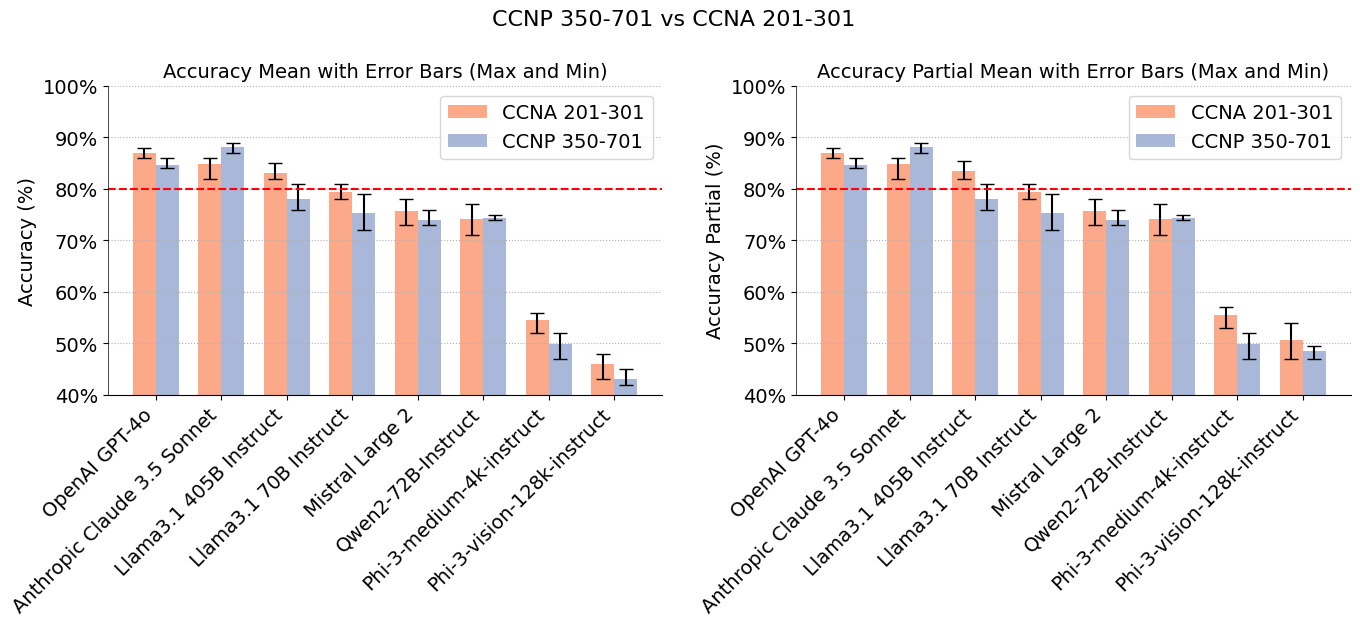

In [2]:
CCNA_folder_paths = ["results/100_questions_5_Shot_201-301-CCNA_2024_08_07_15_43"]
CCNA_model_statistics = stats_from_pickle(CCNA_folder_paths)
CCNP_folder_paths = ["results/100_questions_5_Shot_350-701-CCNP_2024_08_06_15_28"]
CCNP_model_statistics = stats_from_pickle(CCNP_folder_paths)
title="CCNP 350-701 vs CCNA 201-301"

# Setting 'Models' as the index to align the DataFrame rows
CCNA_model_statistics.set_index('Model', inplace=True)
CCNP_model_statistics.set_index('Model', inplace=True)

# Reindex df2 to match the index of df1
CCNP_model_statistics = CCNP_model_statistics.reindex(CCNA_model_statistics.index)
CCNA_model_statistics.reset_index(inplace=True)
CCNP_model_statistics.reset_index(inplace=True)

#sort CCNP_model_statistics the same way CCNA_model_statistics is sorted on the "Model" column
plot_evaluation_CCNA2(CCNA_model_statistics, CCNP_model_statistics,"CCNA 201-301","CCNP 350-701", hline_accuracy=0.8, hline_partial=0.8, title=title)

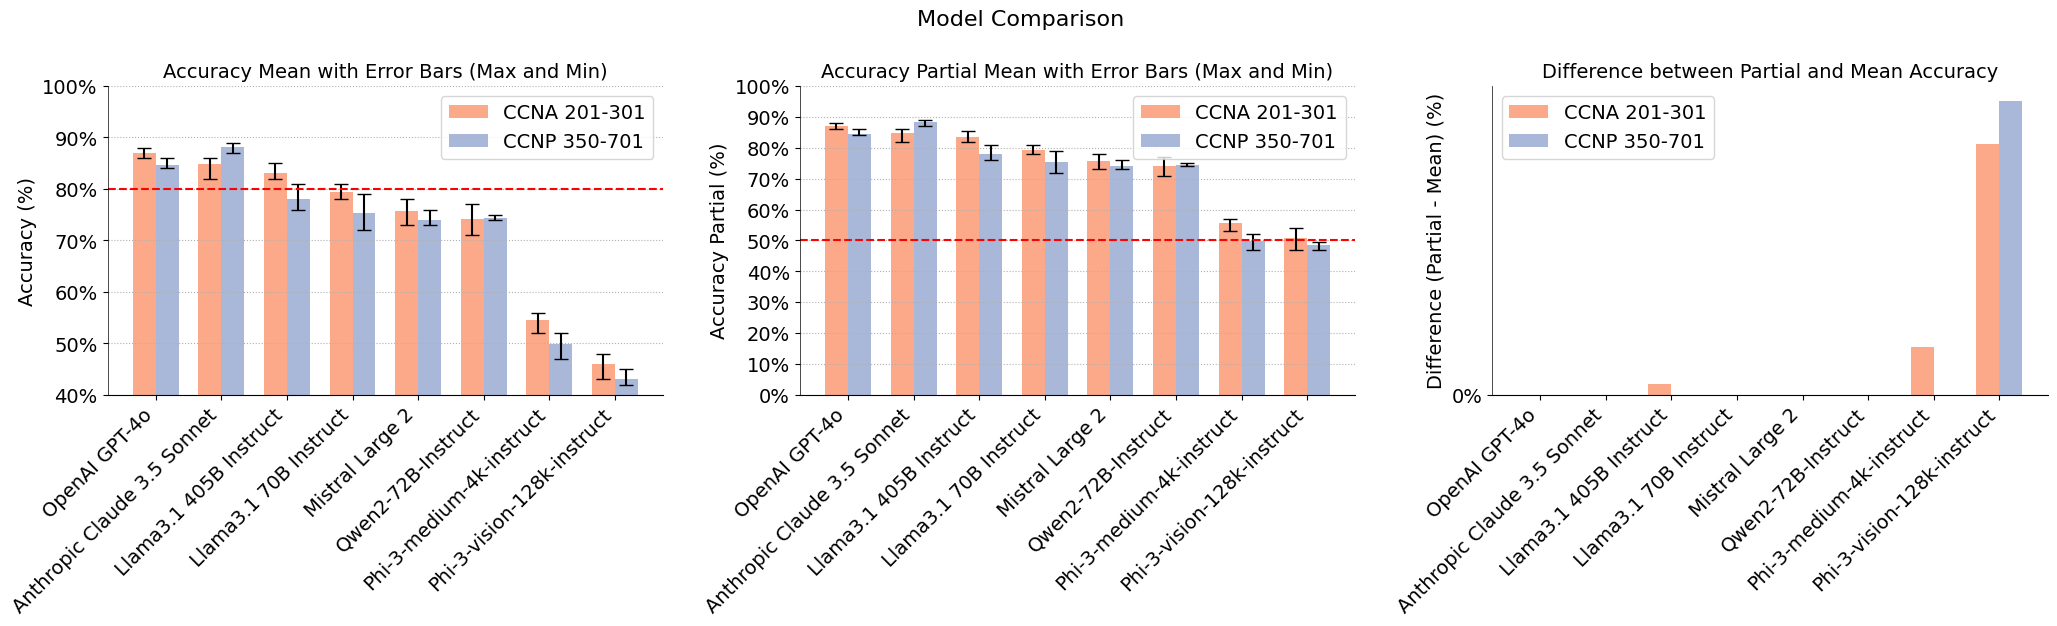

In [3]:
plot_evaluation_CCNA3(CCNA_model_statistics, CCNP_model_statistics,"CCNA 201-301","CCNP 350-701", hline_accuracy=0.8, hline_partial=0.5, title="Model Comparison")

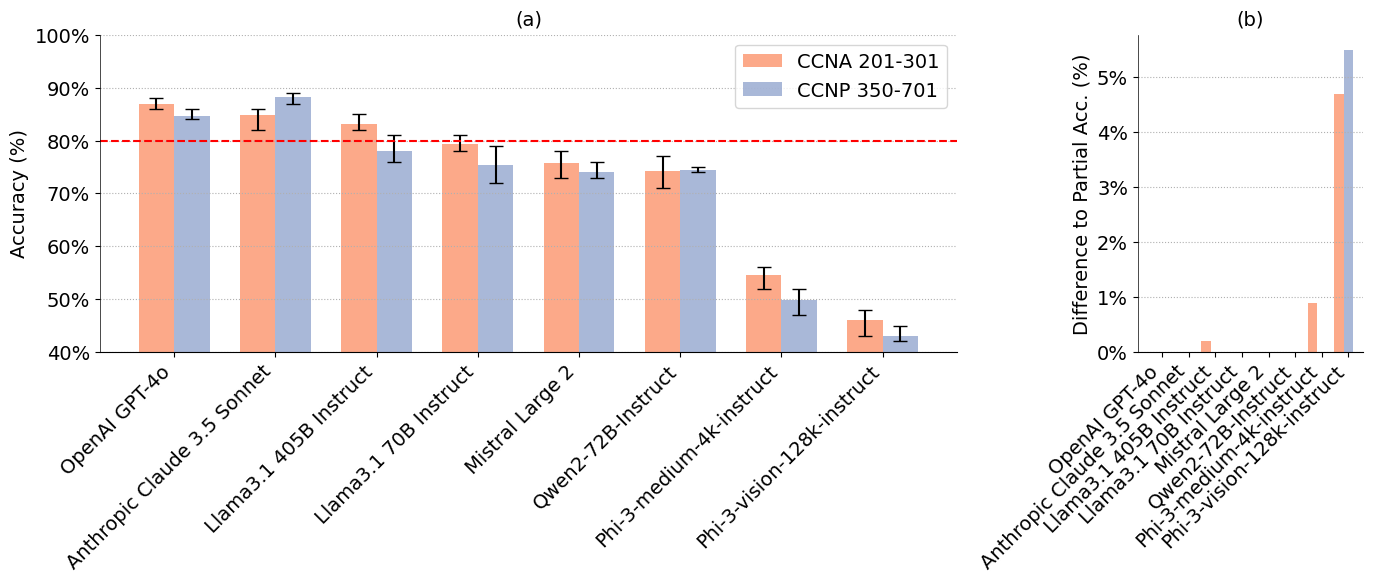

In [4]:
plot_evaluation_CCNA_CCNP(CCNA_model_statistics, CCNP_model_statistics,"CCNA 201-301","CCNP 350-701", hline_accuracy=0.8, hline_partial=0.8)

# COT 

/tmp/ipykernel_146708/2844832456.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  shuffled_evalutation_df = pd.concat([shuffled_evalutation_df, evaluation_df], ignore_index=True)


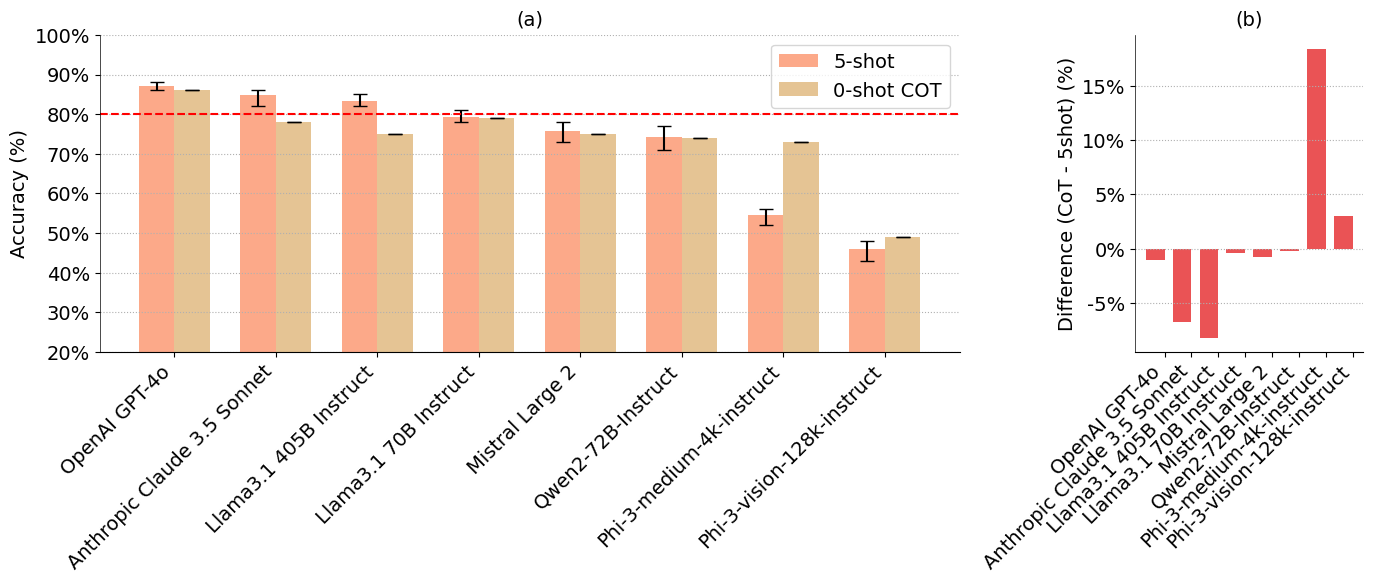

In [5]:
CCNA_COTmodel = ["results/100_questions_0_Shot_COT_201-301-CCNA_2024_08_06_19_15"]
CCNA_COTmodel_statistics = stats_from_pickle(CCNA_COTmodel,cot=True)

# Setting 'Models' as the index to align the DataFrame rows
CCNA_model_statistics.set_index('Model', inplace=True)
CCNA_COTmodel_statistics.set_index('Model', inplace=True)

# Reindex df2 to match the index of df1
CCNA_COTmodel_statistics = CCNA_COTmodel_statistics.reindex(CCNA_model_statistics.index)
CCNA_model_statistics.reset_index(inplace=True)
CCNA_COTmodel_statistics.reset_index(inplace=True)


title="CCNA 201-301 COT"
plot_evaluation_COT_5shot(CCNA_model_statistics, CCNA_COTmodel_statistics,"5-shot","0-shot COT", hline_accuracy=0.8, hline_partial=0.8)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'OpenAI GPT-4o'),
  Text(1, 0, 'Anthropic Claude 3.5 Sonnet'),
  Text(2, 0, 'Llama3.1 405B Instruct'),
  Text(3, 0, 'Llama3.1 70B Instruct'),
  Text(4, 0, 'Mistral Large 2'),
  Text(5, 0, 'Qwen2-72B-Instruct'),
  Text(6, 0, 'Phi-3-medium-4k-instruct'),
  Text(7, 0, 'Phi-3-vision-128k-instruct')])

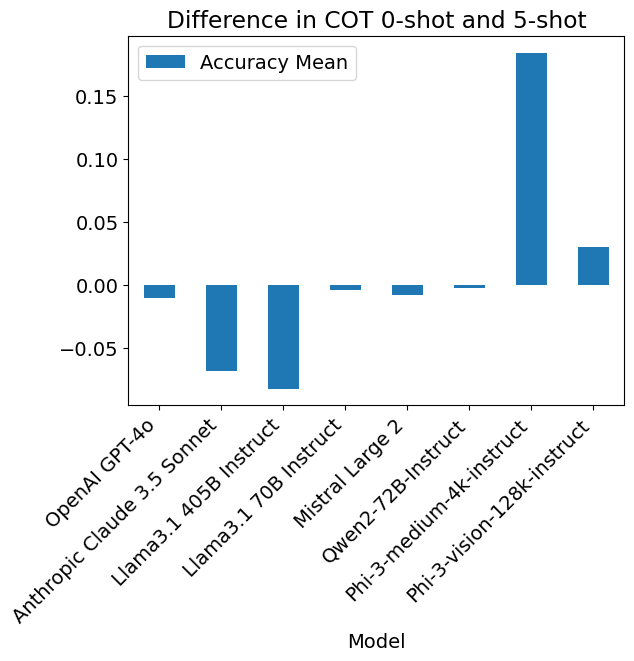

In [6]:
# plot the difference between the two Accuracy Partial and Accuracy
(CCNA_COTmodel_statistics.set_index("Model")["Accuracy Mean"] - CCNA_model_statistics.set_index("Model")["Accuracy Mean"]).dropna().plot(kind="bar", title="Difference in COT 0-shot and 5-shot", legend=True)
#the 0 should be in the midel of the plot so negativ values are shown on the bottom and positive on the top
plt.xticks(rotation=45, ha='right')

# All Together

In [13]:
# Merge Results and rename columns

df1 = CCNA_model_statistics.set_index("Model")[["Accuracy Mean"]].rename(columns={'Accuracy Mean': 'CCNA 201-301'})
df2 = CCNP_model_statistics.set_index("Model")[["Accuracy Mean"]].rename(columns={'Accuracy Mean': 'CCNP 350-701'})
merged_df = pd.merge(df1,df2, on='Model')

#read helm results
helm_results = ["results/100_questions_5_Shot_HELM_mmlu_Computer_Security_2024_08_19_16_05"]
helm_results = stats_from_pickle(helm_results)

#helm_results = pd.read_csv("./data/helm_sec_mmlu_results.csv")
helm_results = helm_results.set_index("Model")[["Accuracy Mean"]].rename(columns={'Accuracy Mean': 'MMLU Computer Security'})
#rename index "phi-3-mini" to "Phi-3-mini-128k-instruct
helm_results = helm_results.rename(index={"Phi-3-mini": "Phi-3-mini-128k-instruct"})
merged_df = pd.merge(merged_df,helm_results, on='Model')

#add CCNA_COTmodel_statistics
#merged_df = pd.merge(merged_df,CCNA_COTmodel_statistics.set_index("Model")[["Accuracy Mean"]].rename(columns={'Accuracy Mean': 'CCNA 201-301 COT'}), on='Model')

#merged_df = merged_df.drop_duplicates(subset='Model', keep='first')
#merged_df = merged_df.sort_values(by="CCNA 201-301", ascending=False).set_index("Model")


/tmp/ipykernel_146708/2844832456.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  shuffled_evalutation_df = pd.concat([shuffled_evalutation_df, evaluation_df], ignore_index=True)


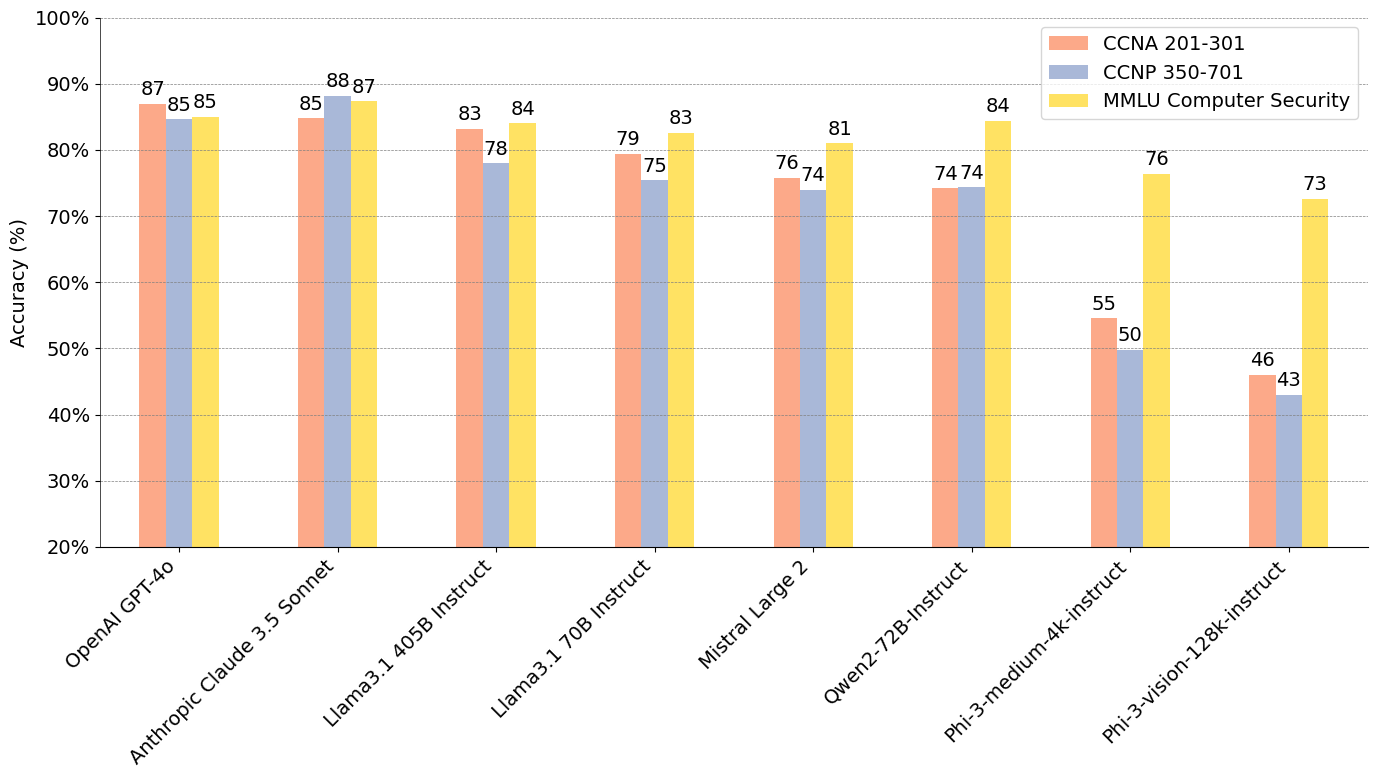

In [14]:
# Plot settings
fig, ax = plt.subplots(figsize=(14, 8))

# Plotting the bars
bars = merged_df.plot(kind='bar', color=[color1,color2,color5], alpha=0.75, ax=ax)

# Adding data labels
# Adding data labels
for p in ax.patches:
    ax.annotate(f'{p.get_height()*100:.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=14)
# Customizing the plot
ax.set_ylabel('Accuracy (%)', fontsize=14)
#ax.set_title('Comparison of Models', fontsize=16, pad=20)
ax.set_xticks(range(len(merged_df.index)))
ax.set_xticklabels(merged_df.index, rotation=45, ha='right', fontsize=14)
ax.set_ylim(0.2, 1)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x * 100)}%'))
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.set_xlabel('')
# Customizing the legend
ax.legend(frameon=True, fontsize=14, loc='upper right')#, bbox_to_anchor=(1, 1))
# increase fond siye of y-axis
plt.yticks(fontsize=14)

# Tight layout for better spacing
plt.tight_layout()

# Save the figure
#plt.savefig("plots/comparison_of_models.png", dpi=600, bbox_inches='tight')
plt.savefig("plots/comparison_of_models.png", dpi=600, bbox_inches='tight')
plt.show()

# Vison

In [9]:
CCNP_Vision_path = ["results/15_questions_5_Shot_350-701-CCNP-VISION_2024_08_07_16_48"]
CCNP_Vision_Stats = stats_from_pickle(CCNP_Vision_path,cot=False)
title="CCNP 350-701 Vision"

CCNA_Vision_path = ["results/70_questions_5_Shot_200-301-CCNA-VISION_2024_08_12_17_13"]
CCNA_Vision_Stats = stats_from_pickle(CCNA_Vision_path,cot=False)
title="CCNA 200-301 Vision"

df1 = CCNA_Vision_Stats.set_index("Model")[["Accuracy Mean"]].rename(columns={'Accuracy Mean': 'CCNA 200-301 Vision'})
df2 = CCNP_Vision_Stats.set_index("Model")[["Accuracy Mean"]].rename(columns={'Accuracy Mean': 'CCNP 350-701 Vision'})
vision_merged_df = pd.merge(df1,df2, on='Model')
# Calculate combined accuracy weighted by the number of questions in the datasets
vision_merged_df['Combined Accuracy'] = (vision_merged_df['CCNA 200-301 Vision'] * 70 + vision_merged_df['CCNP 350-701 Vision'] * 15) / (70 + 15)

vision_merged_df


/tmp/ipykernel_146708/2844832456.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  shuffled_evalutation_df = pd.concat([shuffled_evalutation_df, evaluation_df], ignore_index=True)
/tmp/ipykernel_146708/2844832456.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  shuffled_evalutation_df = pd.concat([shuffled_evalutation_df, evaluation_df], ignore_index=True)


,CCNA 200-301 Vision,CCNP 350-701 Vision,Combined Accuracy
Model,,,
OpenAI GPT-4o,0.728571,0.800000,0.741176
Anthropic Claude 3.5 Sonnet,0.628571,0.733333,0.647059
InternVL2-40B,0.471429,0.466667,0.470588
MiniCPM Llama3 V2.5,0.342857,0.533333,0.376471
Phi-3-vision-128k-instruct,0.285714,0.666667,0.352941


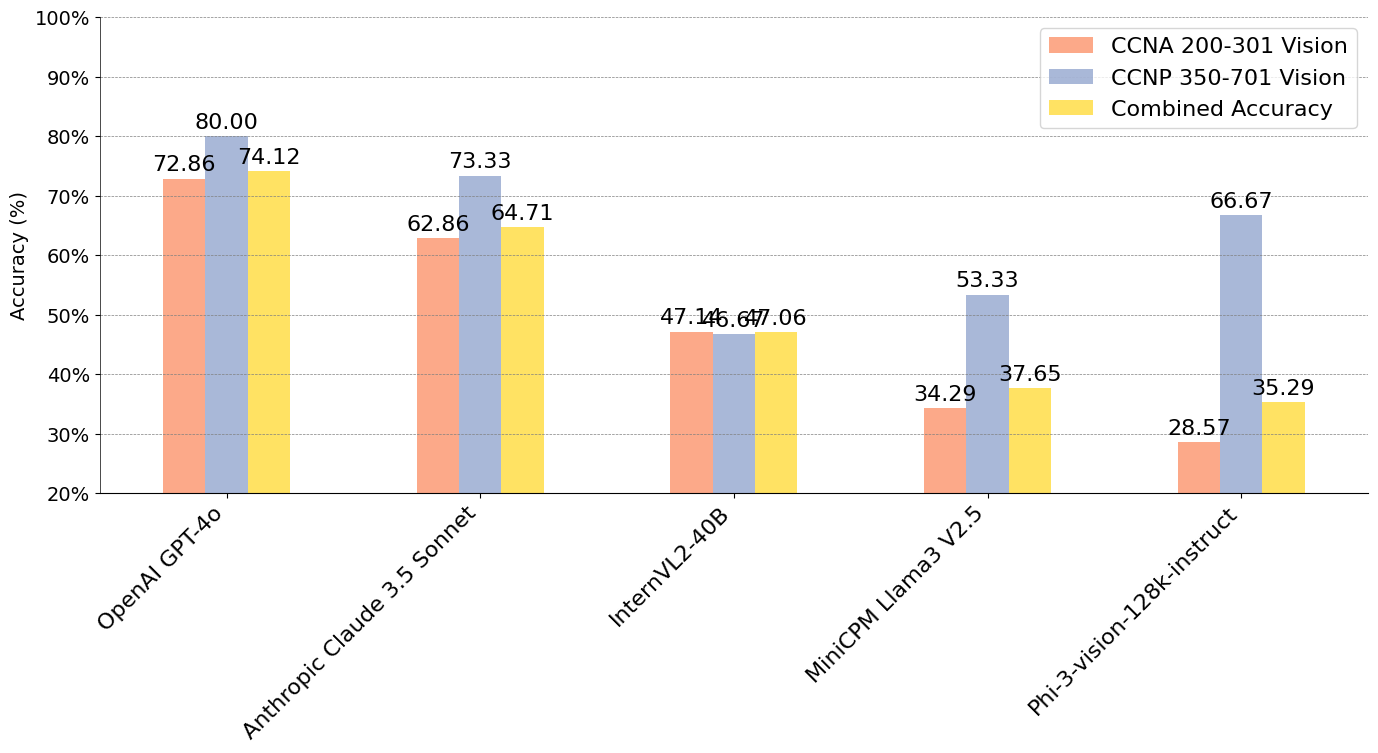

In [10]:

fig, ax = plt.subplots(figsize=(14, 8))
colors = plt.cm.Set2(np.linspace(0, 1, len(merged_df.columns)))
bars = vision_merged_df.plot(kind='bar', color=[color1,color2,color5], alpha=0.75, ax=ax)

# Adding data labels
for p in ax.patches:
    ax.annotate(f'{p.get_height()*100:.2f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=16)

# Customizing the plot
ax.set_ylabel('Accuracy (%)', fontsize=14)
#ax.set_title('Comparison of Models', fontsize=16, pad=20)
ax.set_xticks(range(len(vision_merged_df.index)))
ax.set_xticklabels(vision_merged_df.index, rotation=45, ha='right', fontsize=16)
ax.set_ylim(0.2, 1)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x * 100)}%'))
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)

# Customizing the legend
ax.legend(frameon=True, fontsize=16, loc='upper right')#, bbox_to_anchor=(1, 1))

# Tight layout for better spacing
plt.tight_layout()
# Remove x-axis labels
ax.set_xlabel('')

#Save the figure
plt.savefig("plots/vision.png", dpi=600, bbox_inches='tight')
plt.show()